# Pipeline for phase change materials. Scripting example

Consists of three sections:

* Separate sample from background
* Crystallinity map generation
* Region clustering

File: 4D STEM of phase change material, Vadim Migunov et al. TODO update to proper credit

In [1]:
%matplotlib inline

import functools
import os

from skimage.feature import peak_local_max
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sklearn.feature_extraction
import sklearn.cluster
import scipy.sparse
import sparse

from libertem.udf import UDF
from libertem import masks
from libertem.api import Context
from libertem.udf.masks import ApplyMasksUDF
from libertem.udf.stddev import run_stddev
from  libertem.udf.crystallinity import run_analysis_crystall

## Crystallinity map generation

In [2]:
data_base_path = os.environ.get("TESTDATA_BASE_PATH", "/home/alex/Data/")

In [3]:
ctx = Context()
ds = ctx.load("auto", path=os.path.join(data_base_path, "01_ms1_3p3gK.hdr"))

In [4]:
cy = 125.7
cx = 124.9
fy, fx = tuple(ds.shape.sig)
y, x = tuple(ds.shape.nav)
r = 3

Use `libertem.udf.masks.ApplyMasksUDF` to calculate brightfield and darkfield image for segmentation between sample and membrane.

In [5]:
ring = functools.partial(
    masks.ring,
    centerX=cx,
    centerY=cy,
    imageSizeX=fx,
    imageSizeY=fy,
    radius=160,
    radius_inner=100,
)
disk = functools.partial(
    masks.circular,
    centerX=cx,
    centerY=cy,
    imageSizeX=fx,
    imageSizeY=fy,
    radius=1,
    antialiased=True
)
segmentation_udf = ApplyMasksUDF(
    mask_factories=[ring, disk],
)

In [6]:
segmentation = ctx.run_udf(udf=segmentation_udf, dataset=ds, progress=True)

Partitions 0/32, Frames:   0%|          | 0/66402 [00:00<?, ?it/s]

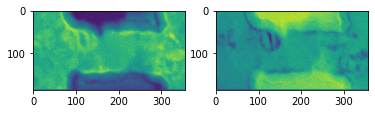

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(segmentation['intensity'].data[..., 0])
axes[1].imshow(segmentation['intensity'].data[..., 1])

The amorphous membrane (substrate) is masked out in subsequent processing to reduce the amount of computation and improve the clustering result.

We use agglomerative clustering with brightfield and darkfield value as feature vector. The connectivity matrix ensures that only neighboring pixels can belong to the same cluster.

In [9]:
connectivity = scipy.sparse.csr_matrix(
    sklearn.feature_extraction.image.grid_to_graph(
        # Transposed!
        n_x=y,
        n_y=x,
    )
)

clusterer = sklearn.cluster.AgglomerativeClustering(
    metric='euclidean',
    n_clusters=3,
    linkage='ward',
    connectivity=connectivity,
)

In [10]:
clusterer.fit(segmentation['intensity'].data.reshape(-1, 2))
labels = clusterer.labels_.reshape((y, x))

The scan dimension is clustered in three regions: Center, upper membrane and lower membrane. We identify the cluster class of the sample by evaluating the central pixel. Then we create a region of interest (ROI) of all pixels with this label.

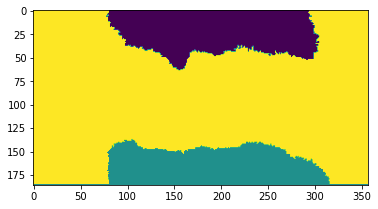

In [11]:
fig, axes = plt.subplots()
plt.imshow(labels)

In [12]:
center_label = labels[y//2, x//2]
center_roi = labels == center_label

To highlight crystalline regions of a phase change material, use `libertem.udf.crystallinity`, which is integrating over the ring with `rad_in` and `rad_out` each frame spectrum which belongs to `roi`. The result is a measure of how present diffraction peaks besides the zero order peak are in each frame. Since the grains have random orientations, this value fluctuates strongly.

In [13]:
crystal_res = run_analysis_crystall(ctx, ds, rad_in=6, rad_out=60,
                              real_center=(cy, cx), real_rad=6, roi=center_roi, progress=True)
crystal = crystal_res["intensity"].data

Partitions 0/32, Frames:   0%|          | 0/47721 [00:00<?, ?it/s]

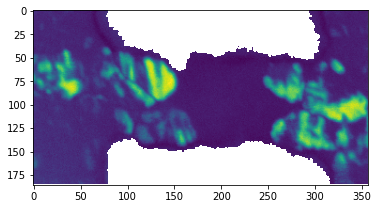

In [14]:
plt.figure()
plt.imshow(np.log(crystal))

## Sample region clustering

To generate a feature fector, we first generate a standard deviation map using `libertem.udf.stddev`. Then we find maxima in this standard deviation map and use the pixel value of these positions to generate a feature vector for each frame.


In [15]:
stddev_res = run_stddev(ctx=ctx, dataset=ds, roi=center_roi, progress=True)

Partitions 0/32, Frames:   0%|          | 0/47721 [00:00<?, ?it/s]

In [16]:
peaks = peak_local_max(stddev_res['std'], min_distance=3, num_peaks=500)

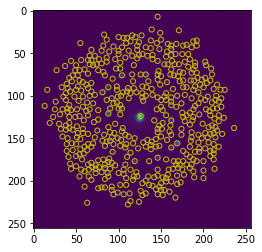

In [17]:
fig, axes = plt.subplots()
plt.imshow(stddev_res['std'])
for p in np.flip(peaks, axis=-1):
    axes.add_artist(plt.Circle(p, r, color="y", fill=False))

We use `libertem.udf.masks.ApplyMasksUDF` with a very sparse mask stack to select the pixel values for each frame. This operation is very efficient.

In [18]:
masks = sparse.COO(
    shape=(len(peaks), fy, fx),
    coords=(range(len(peaks)), peaks[..., 0], peaks[..., 1]),
    data=1.
)
feature_udf = ApplyMasksUDF(
    mask_factories=lambda: masks,
    mask_dtype=bool,
    mask_count=len(peaks),
    use_sparse=True
)

In [19]:
%time feature_res = ctx.run_udf(udf=feature_udf, dataset=ds, roi=center_roi, progress=True)

Partitions 0/32, Frames:   0%|          | 0/47721 [00:00<?, ?it/s]

CPU times: user 7.05 s, sys: 1.13 s, total: 8.19 s
Wall time: 24 s


Normalize the feature vectors to make sure that strong peaks don't dominate the distance calculation.

In [20]:
f = feature_res['intensity'].raw_data
feature_vector = f / np.abs(f).mean(axis=0)

Clustering can be done with any of clustering algorithm you like. Agglomerative clustering with a connectivity matrix for neighboring pixels lke shown here usually works well. Since the image is large in the scan dimension, the clustering can be somewhat time-consuming.

In [21]:
%%time
roi_connectivity = connectivity[center_roi.flatten()][..., center_roi.flatten()]
clustering = sklearn.cluster.AgglomerativeClustering(
    metric='euclidean',
    distance_threshold=300,
    n_clusters=None,
    linkage='ward',
    connectivity=roi_connectivity
).fit(feature_vector)

labels = np.array(clustering.labels_+1)
labelmask=np.full((y, x), np.nan)
labelmask[center_roi]=labels

CPU times: user 1min 14s, sys: 2.99 s, total: 1min 17s
Wall time: 1min 16s


Visualize the clustering result. Note that the difference between the value assigned to each class is not a measure of similarity. A discrete color scale would be best-suited. Tab20 with 20 entries is the largest available in matplotlib and we have significantly more clusters. HSV usually achieves an acceptable differentiation of discrete values beyond 20.

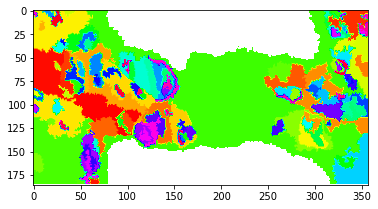

In [22]:
fig, axes = plt.subplots()
plt.imshow(labelmask, cmap=cm.hsv)